In [41]:
from tqdm import tqdm
import random
import torch
import numpy as np
import scanpy as sc
import muon as mu
import pandas as pd
import scipy.sparse as sp
from omegaconf import OmegaConf
from copy import deepcopy
from cfgen.data.scrnaseq_loader import RNAseqLoader
from cfgen.models.base.encoder_model import EncoderModel
from cfgen.models.fm.fm import FM
from scvi.distributions import NegativeBinomial

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(4, 4)) 

## Initialize dataset and encoder

In [69]:
dataset_conf = OmegaConf.load("../../configs/configs_sccfm/dataset/pbmc10k_multimodal.yaml")
encoder_conf = OmegaConf.load("../../configs/configs_encoder/encoder/encoder_multimodal_joint.yaml")
encoder_conf["is_binarized"] = True

In [70]:
dataset_conf.is_binarized

True

Initialize dataset

In [71]:
dataset = RNAseqLoader(dataset_conf.dataset_path,
                        layer_key=dataset_conf.layer_key,
                        covariate_keys=dataset_conf.covariate_keys,
                        subsample_frac=dataset_conf.subsample_frac, 
                        normalization_type=dataset_conf.normalization_type,
                        is_binarized=dataset_conf.is_binarized)

dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=64,
                                        shuffle=False,
                                        drop_last=False)

in_dim = {"rna": dataset.X["rna"].shape[1],
          "atac": dataset.X["atac"].shape[1]}

size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


Initialize Autoencoder

In [72]:
gene_dim = {mod: dataset.X[mod].shape[1] for mod in dataset.X}

encoder_model = EncoderModel(in_dim=gene_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_conf.theta_covariate, 
                              **encoder_conf)

In [73]:
state_dict_path = "../../project_folder/experiments/autoencoder_ckpt/train_autoencoder_pbmc10k_multimodal_joint/checkpoints/last.ckpt"
encoder_model.load_state_dict(torch.load(state_dict_path, weights_only=False)["state_dict"])

<All keys matched successfully>

## Initialize Flow Matching model

In [74]:
generative_model_config = OmegaConf.load("../../configs/configs_sccfm/generative_model/default.yaml")

In [75]:
ckpt = torch.load("../../project_folder/experiments/cfgen_ckpt/train_fm_pbmc10k_multimodal_joint/last.ckpt", weights_only=False)

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [76]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 0.2293, -1.6836, -1.8448,  ...,  0.0806,  1.2136, -1.5143],
        [ 1.8911,  0.1352, -0.9429,  ..., -2.4912,  1.2032, -0.9426],
        [ 0.7407, -1.6780, -0.3861,  ..., -0.0238, -2.7400,  0.0323],
        ...,
        [-0.3023,  0.6549,  1.0073,  ...,  0.8178,  0.5114,  0.3643],
        [-1.1059, -1.6496,  0.9139,  ...,  0.5118,  0.9771,  1.2190],
        [ 1.2144,  1.3687, -1.1835,  ...,  0.3673, -0.2555,  0.6764]],
       device='cuda:0', requires_grad=True)


In [82]:
generative_model = FM(encoder_model=encoder_model,
                        denoising_model=denoising_model,
                        feature_embeddings=feature_embeddings,
                        plotting_folder=None,
                        in_dim={"rna": 100},
                        size_factor_statistics=size_factor_statistics,
                        covariate_list=["cell_type"],
                        theta_covariate="cell_type",
                        size_factor_covariate="cell_type",
                        is_binarized=True,
                        modality_list=["rna", "atac"],
                        guidance_weights={"cell_type": 1},
                        **generative_model_config  # model_kwargs should contain the rest of the arguments
                        )

# generative_model.denoising_model.embed_size_factor = True
generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (encoder): ModuleDict(
      (rna): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=25604, out_features=512, bias=True)
            (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
            (0): Linear(in_features=512, out_features=300, bias=True)
            (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (2): Linear(in_features=300, out_features=100, bias=True)
        )
      )
      (atac): MLP(
        (net): Sequential(
          (0): Sequential(
            (0): Linear(in_features=40086, out_features=1024, bias=True)
            (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ELU(alpha=1.0)
          )
          (1): Sequential(
         

## Load real dataset 

In [83]:
adata_original = mu.read(dataset_conf["dataset_path"])
adata_rna = adata_original.mod["rna"]
adata_atac = adata_original.mod["atac"]
adata_rna.obs["size_factor"]=adata_rna.X.todense().sum(1)
adata_atac.obs["size_factor"]=adata_atac.X.todense().sum(1)
X_rna = torch.tensor(adata_rna.layers["X_counts"].todense())
X_atac = torch.tensor(adata_atac.layers["X_counts"].todense())

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [84]:
adata_original

MuData object with n_obs × n_vars = 8000 × 65690
  2 modalities
    rna:	8000 x 25604
      obs:	'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'size_factor'
      var:	'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'cell_type_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'X_counts', 'count'
      obsp:	'connectivities', 'distances'
    atac:	8000 x 40086
      obs:	'cell_type', 'size_factor'
      uns:	'cell_type_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'X_counts', 'cpm_norm', 'tf-idf'
      obsp:	'connectivities', 'distances'

## Generate and save cells

In [91]:
X_generated_list_rna = []
X_generated_list_atac = []

classes_str = []

for _ in tqdm(range(8)):
    num_indices = 1000
    adata_rna_indices = adata_rna[indices]
    adata_atac_indices = adata_atac[indices]
    
    # Sample conditions from the data (roughly keeps the same observed proportions)
    indices = random.sample(range(index_range), num_indices)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_rna_indices.obs.cell_type) 
    classes_str += classes
    classes = {"cell_type": torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes]).cuda()}

    log_size_factors = torch.log(torch.tensor(adata_rna_indices.layers["X_counts"].sum(1))).cuda()
    X_generated = generative_model.batched_sample(batch_size=100,
                                                    repetitions=10,
                                                    n_sample_steps=2, 
                                                    theta_covariate="cell_type", 
                                                    size_factor_covariate="cell_type", 
                                                    conditioning_covariates=["cell_type"],
                                                    covariate_indices=classes, 
                                                    log_size_factor=log_size_factors)

    X_generated_list_rna.append(X_generated["rna"].to("cpu"))
    X_generated_list_atac.append(X_generated["atac"].to("cpu"))

100%|██████████| 8/8 [00:48<00:00,  6.11s/it]


In [92]:
X_generated_rna_list = torch.cat(X_generated_list_rna, dim=0)
X_generated_atac_list = torch.cat(X_generated_list_atac, dim=0)

In [93]:
dataset_type_rna = ["Real" for _ in range(X_rna.shape[0])] + ["Generated" for _ in range(X_generated_rna_list.shape[0])]
dataset_type_rna = pd.DataFrame(dataset_type_rna)
dataset_type_rna.columns = ["dataset_type"]
dataset_type_rna["classes"] = list(adata_rna.obs.cell_type)+list(classes_str)

In [104]:
dataset_type_atac= ["Real" for _ in range(X_atac.shape[0])] + ["Generated" for _ in range(X_generated_atac_list.shape[0])]
dataset_type_atac = pd.DataFrame(dataset_type_atac)
dataset_type_atac.columns = ["dataset_type"]
dataset_type_atac["classes"] = list(adata_rna.obs.cell_type)+list(classes_str)

In [105]:
adata_merged_rna = sc.AnnData(X=torch.cat([X_rna, X_generated_rna_list], dim=0).numpy(), 
                             obs=dataset_type_rna)

adata_merged_atac = sc.AnnData(X=torch.cat([X_atac, X_generated_atac_list], dim=0).numpy(), 
                             obs=dataset_type_atac)

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [96]:
sc.pp.log1p(adata_merged_rna) 
sc.tl.pca(adata_merged_rna)
sc.pp.neighbors(adata_merged_rna)
sc.tl.umap(adata_merged_rna)

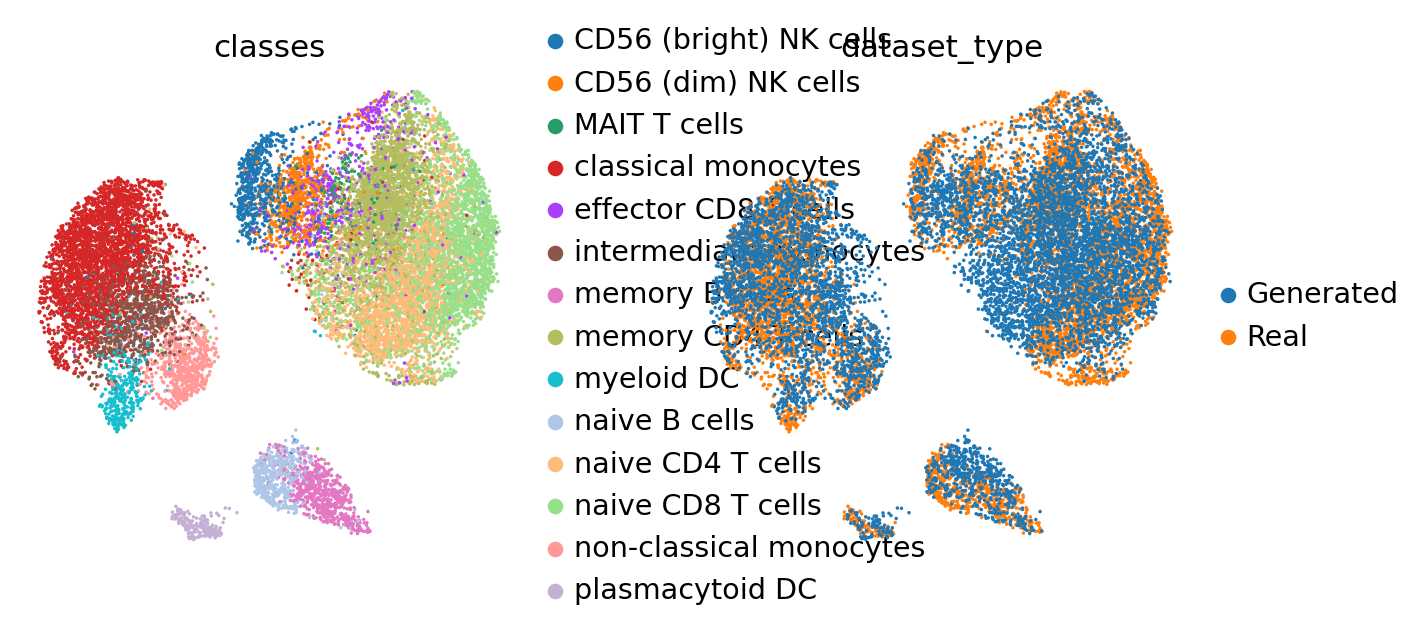

In [101]:
sc.pl.umap(adata_merged_rna, color=["classes","dataset_type"], s=10)

In [106]:
sc.pp.log1p(adata_merged_atac) 
sc.tl.pca(adata_merged_atac)
sc.pp.neighbors(adata_merged_atac)
sc.tl.umap(adata_merged_atac)

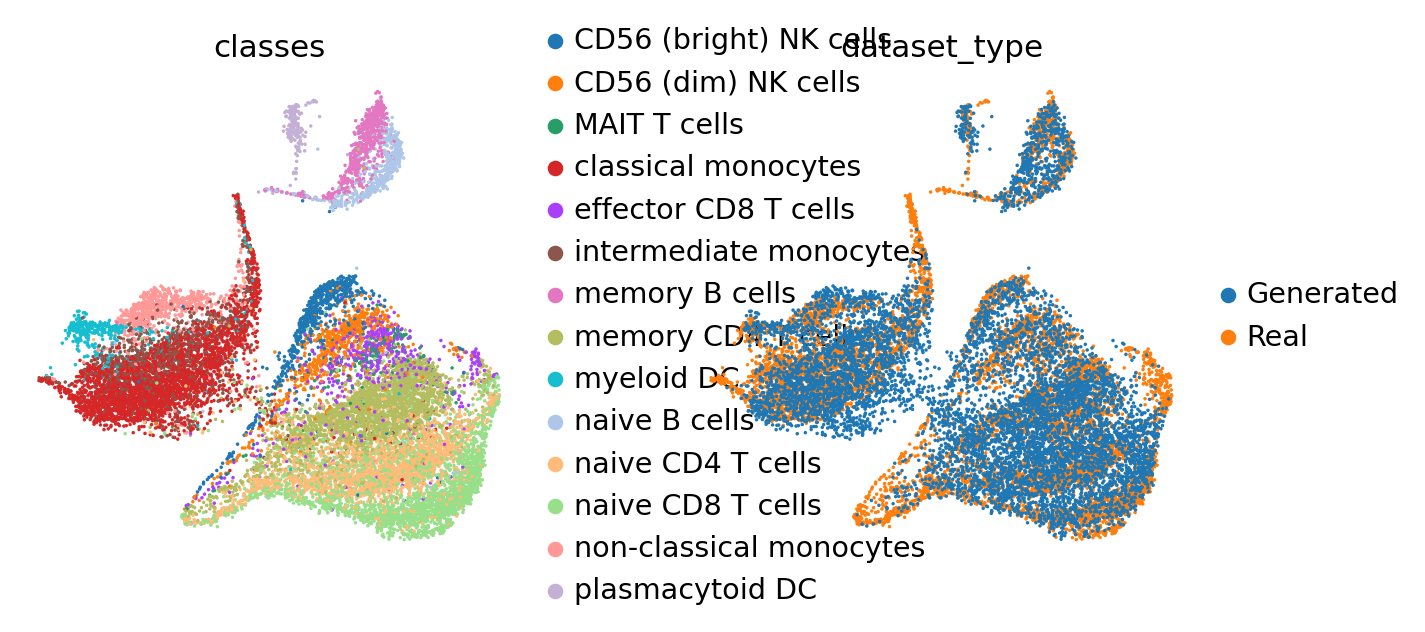

In [107]:
sc.pl.umap(adata_merged_atac, color=["classes","dataset_type"], s=10)